In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Carregar os dados
df = pd.read_csv("telcoCustomerChurn.csv")

In [3]:
# --- Seleção de Variáveis ---
# Remover colunas que não serão usadas como features
# customerID é um identificador.
# TotalCharges está diretamente correlacionado com MonthlyCharges e tenure, não deve ser usado como feature.
# Churn é o resultado de um serviço, não uma causa da mensalidade.
df.drop(['customerID', 'TotalCharges', 'Churn'], axis=1, inplace=True, errors='ignore')


In [4]:
# Definir a variável alvo (y) e as features (X)
y = df['MonthlyCharges']
X = df.drop('MonthlyCharges', axis=1)

In [5]:
# --- Identificar Features Numéricas e Categóricas ---
# SeniorCitizen é numérico (0/1) mas funciona como uma categoria
# Vamos tratá-lo como numérico aqui
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [6]:
print(f"Variável Alvo (y): MonthlyCharges")
print(f"\nFeatures Numéricas (X): {numerical_features}")
print(f"Features Categóricas (X): {categorical_features}")

Variável Alvo (y): MonthlyCharges

Features Numéricas (X): ['SeniorCitizen', 'tenure']
Features Categóricas (X): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [7]:
# --- Criar Pipeline de Pre-processamento ---

# Pipeline para features numéricas: Apenas escalonamento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [8]:
# Pipeline para features categóricas: One-Hot Encoding
# Usamos sparse=False para compatibilidade e facilidade de inspeção
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])

In [9]:
# Combinar os pipelines no ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [10]:
# --- Dividir Dados em Treino e Teste ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# --- Criar e Treinar o Pipeline Final ---
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [14]:
model.fit(X_train, y_train)
print("\nModelo de Regressão Linear Múltipla treinado com sucesso!")


Modelo de Regressão Linear Múltipla treinado com sucesso!


In [15]:
# --- Avaliar o Modelo ---
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [16]:
print("\n--- Resultados da Avaliação do Modelo ---")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


--- Resultados da Avaliação do Modelo ---
R² (Coeficiente de Determinação): 0.9988
Mean Squared Error (MSE): 1.1050
Mean Absolute Error (MAE): 0.7892


In [17]:
# Interpretação das métricas
print(f"\nO modelo consegue explicar aproximadamente {r2:.1%} da variação no valor da mensalidade.")
print(f"Em média, o erro de previsão do modelo é de R$ {mae:.2f} (valor absoluto).")


O modelo consegue explicar aproximadamente 99.9% da variação no valor da mensalidade.
Em média, o erro de previsão do modelo é de R$ 0.79 (valor absoluto).


In [18]:
# --- Interpretação dos Coeficientes ---
print("\n--- Análise dos Coeficientes do Modelo ---")


--- Análise dos Coeficientes do Modelo ---


In [19]:
# Obter os nomes das features após o OneHotEncoding
try:
    one_hot_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    one_hot_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)
    
    # Nomes finais de todas as features
    all_feature_names = numerical_features + list(one_hot_feature_names)
    
    # Obter os coeficientes do regressor treinado
    coefficients = model.named_steps['regressor'].coef_
    
    # Criar um DataFrame para fácil visualização
    coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient (Impacto em R$)': coefficients})
    
    # Ordenar por valor absoluto para ver os maiores impactos
    coef_df['Impacto_Absoluto'] = coef_df['Coefficient (Impacto em R$)'].abs()
    coef_df = coef_df.sort_values(by='Impacto_Absoluto', ascending=False).drop(columns='Impacto_Absoluto')

    print("Principais fatores que influenciam a mensalidade:")
    print(coef_df.head(15))

except Exception as e:
    print(f"Não foi possível extrair e exibir os coeficientes. Erro: {e}")

Principais fatores que influenciam a mensalidade:
                                 Feature  Coefficient (Impacto em R$)
9                     InternetService_No                 5.172153e+12
6         MultipleLines_No phone service                -2.519146e+12
5                       PhoneService_Yes                -2.519146e+12
12      OnlineBackup_No internet service                -8.883859e+11
16       TechSupport_No internet service                -8.687623e+11
20   StreamingMovies_No internet service                -8.616600e+11
18       StreamingTV_No internet service                -8.616226e+11
14  DeviceProtection_No internet service                -8.518076e+11
10    OnlineSecurity_No internet service                -8.399145e+11
8            InternetService_Fiber optic                 2.494441e+01
19                       StreamingTV_Yes                 9.988385e+00
21                   StreamingMovies_Yes                 9.950508e+00
11                    OnlineSecurity_Yes


--- Gerando Gráfico de Desempenho do Modelo ---


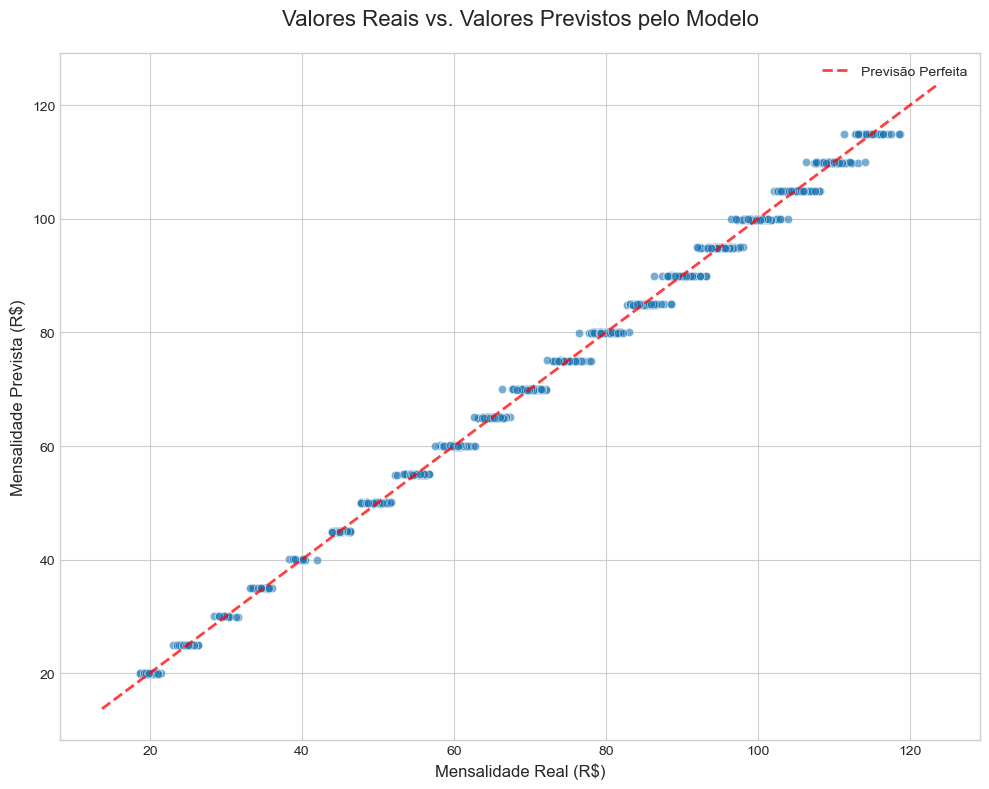

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- 9. GERAR GRÁFICO DA ANÁLISE ---
print("\n--- Gerando Gráfico de Desempenho do Modelo ---")

# CORREÇÃO AQUI: Usando um estilo mais compatível
plt.style.use('seaborn-whitegrid') 
fig, ax = plt.subplots(figsize=(10, 8))

# Criar o scatter plot de valores reais vs. previstos
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax)
ax.set_xlabel("Mensalidade Real (R$)", fontsize=12)
ax.set_ylabel("Mensalidade Prevista (R$)", fontsize=12)
ax.set_title("Valores Reais vs. Valores Previstos pelo Modelo", fontsize=16, pad=20)

# Adicionar a linha de referência (y=x), onde a previsão seria perfeita
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'r--', alpha=0.75, lw=2, label='Previsão Perfeita')

ax.legend()
plt.tight_layout()
plt.show()
